## Import Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import isnan
%matplotlib inline

## Read data from csv files

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Preprocess

#### find the features with correlation less than 0.3 with salesprice

In [3]:
corr_heatmap = train_df.corr()

kot = corr_heatmap[['SalePrice']]
kot = kot[abs(kot) < 0.3]
kot = kot.dropna()
kot.sort_values(by='SalePrice')
drop_list = list(kot.index)

#### split labels and delete from train data


In [4]:
labels = train_df['SalePrice'].values
train_df = train_df.drop(['SalePrice'],axis=1)

df = pd.concat([train_df,test_df])
test_df_id = test_df[['Id']]

#### drop the features which they don't have any ocrrelation with salesprice


In [5]:
df = df.drop(drop_list, axis=1)

#### drop features which half of them or more is nan!


In [6]:
threshold = 0.5
norm_null = df.isnull().sum()/len(df)
dropped_features = norm_null.loc[norm_null > threshold].index
df = df.drop(dropped_features,axis=1)

#### fill nan values 

In [7]:
no_list = ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
zero_list = ['GarageCars', 'GarageArea']
mean_list = ["LotFrontage","MasVnrArea","TotalBsmtSF", "BsmtFinSF1"]
frequent_list = ["MasVnrType","MSZoning","Utilities","Exterior1st","Exterior2nd","Functional","KitchenQual","SaleType","Electrical"]
categorical_list = ["MSZoning","Street","LotShape",\
                              "LandContour","Utilities","LotConfig",\
                              "LandSlope","Neighborhood","Condition1",\
                              "Condition2","BldgType","HouseStyle",\
                              "RoofStyle","RoofMatl","Exterior1st",\
                              "Exterior2nd","MasVnrType","ExterQual",\
                              "ExterCond","Foundation","BsmtQual",\
                              "BsmtCond","BsmtExposure","BsmtFinType1",\
                              "BsmtFinType2","Heating","HeatingQC",\
                              "CentralAir","Electrical","KitchenQual",\
                              "Functional","FireplaceQu","GarageType",\
                              "GarageYrBlt","GarageFinish","GarageQual",\
                              "GarageCond","PavedDrive","SaleType","SaleCondition"]

for i in no_list:
    df[i].fillna("No",inplace=True)

for i in zero_list:
    df[i].fillna(0,inplace=True)

for i in mean_list:
    df[i].fillna(df[i].mean(),inplace=True)

for i in frequent_list:
    df[i].fillna(df[i].mode()[0],inplace=True)

#### categorical to sparse


In [8]:
df = pd.get_dummies(df, columns = categorical_list, prefix= categorical_list, drop_first=True)

#### feature normalization

In [9]:
df = (df-df.min())/(df.max()-df.min())

#### split data again in train and test

In [10]:
train_csv = df.iloc[:train_df.shape[0],:].values
test_csv = df.iloc[train_df.shape[0]:,:].values

#### split train data in to train and validation

In [11]:
split_rate = 0.15
number_of_tests = int(train_csv.shape[0] * split_rate)
indices = np.random.permutation(train_csv.shape[0])
test_idx, train_idx = indices[:number_of_tests], indices[number_of_tests:]
test_x, train_x = train_csv[test_idx,:], train_csv[train_idx,:]
test_y, train_y = labels[test_idx], labels[train_idx]

#### RMSE and MSE definition

In [12]:
def mse(y1, y2):
    return np.mean((y1-y2)**2)

def rmse(y1, y2):
    return np.sqrt(mse(y1, y2))

## Kernel Implementation
$$
w\left(x, x_{i}\right)=\frac{K\left(\frac{x_{i}-x}{h}\right)}{\sum_{j=1}^{n} K\left(\frac{x_{j}-x}{h}\right)}
$$

In [13]:
def safe_devide(x1,x2):
    try:
        ans = x1/x2
    except:
        ans = 0
    return ans
      
class Kernel_Regression_Model:    
    def __init__(self, inp, out, parameter):
        self.inp = inp
        self.out = out
        self.p = parameter
    
    def one(self, i):
        if i > self.p:
            return 0
        else: 
            return 1
        
    def predict_one(self, x_test):
        kernels = np.array([self.one(np.linalg.norm(i-x_test)) for i in self.inp])
        weights = np.array([len(self.inp) * safe_devide(k, np.sum(kernels)) for k in kernels])
        return safe_devide(np.dot(weights.T, self.out),len(self.inp))
    
    def gaussian(self, i):
        std = -0.5*(i/self.p)**2
        pre = 1/(np.sqrt(2*np.pi) * self.p)
        try:
            post = np.exp(std)
        except:
            post = 0 
        try:
            final = pre*post
        except:
            final = 0
        return final
        
    def predict_gaussian(self, x_test):
        kernels = np.array([self.gaussian(np.linalg.norm(i-x_test)) for i in self.inp])
        weights = np.array([len(self.inp) * safe_devide(k, np.sum(kernels)) for k in kernels])
        return safe_devide(np.dot(weights.T, self.out),len(self.inp))    

#### Test

In [25]:
RMSE_gaussian = dict()
RMSE_one = dict()
paramters = list(np.arange(0,20,0.1)) + list(np.arange(0,0.1,0.01))

In [54]:
for p in paramters:
    model = Kernel_Regression_Model(train_x, train_y, p)
    RMSE_gaussian[p] = rmse(test_y, np.array([model.predict_gaussian(i) for i in test_x]))
    RMSE_one[p] = rmse(test_y, np.array([model.predict_one(i) for i in test_x]))

In [29]:
RMSE_gaussian

{0.0: nan,
 0.1: nan,
 0.2: 37396.61012194062,
 0.30000000000000004: 37542.54840203008,
 0.4: 37338.15879206472,
 0.5: 36752.64689331125,
 0.6000000000000001: 36063.44224621169,
 0.7000000000000001: 35354.6444475318,
 0.8: 34902.04981146786,
 0.9: 34921.33849769372,
 1.0: 35523.62148010559,
 1.1: 36662.71727317121,
 1.2000000000000002: 38189.7204124551,
 1.3: 39942.0208734158,
 1.4000000000000001: 41778.49283334112,
 1.5: 43602.46647838164,
 1.6: 45355.146774551475,
 1.7000000000000002: 47006.47997094263,
 1.8: 48545.24516190715,
 1.9000000000000001: 49970.041262037645,
 2.0: 51283.95143181192,
 2.1: 52492.10692010631,
 2.2: 53600.65908991859,
 2.3000000000000003: 54616.28941619299,
 2.4000000000000004: 55545.90549894245,
 2.5: 56396.4135415623,
 2.6: 57174.54246207397,
 2.7: 57886.715274027905,
 2.8000000000000003: 58538.963994404585,
 2.9000000000000004: 59136.881620710956,
 3.0: 59685.60320868795,
 3.1: 60189.80816203846,
 3.2: 60653.73689172911,
 3.3000000000000003: 61081.216405103

In [30]:
RMSE_one

{0.0: nan,
 0.1: nan,
 0.2: nan,
 0.30000000000000004: nan,
 0.4: nan,
 0.5: nan,
 0.6000000000000001: nan,
 0.7000000000000001: nan,
 0.8: nan,
 0.9: nan,
 1.0: nan,
 1.1: nan,
 1.2000000000000002: nan,
 1.3: nan,
 1.4000000000000001: nan,
 1.5: nan,
 1.6: nan,
 1.7000000000000002: nan,
 1.8: nan,
 1.9000000000000001: nan,
 2.0: nan,
 2.1: nan,
 2.2: nan,
 2.3000000000000003: nan,
 2.4000000000000004: nan,
 2.5: nan,
 2.6: nan,
 2.7: nan,
 2.8000000000000003: nan,
 2.9000000000000004: nan,
 3.0: nan,
 3.1: nan,
 3.2: nan,
 3.3000000000000003: nan,
 3.4000000000000004: nan,
 3.5: nan,
 3.6: nan,
 3.7: nan,
 3.8000000000000003: nan,
 3.9000000000000004: nan,
 4.0: nan,
 4.1000000000000005: nan,
 4.2: nan,
 4.3: nan,
 4.4: nan,
 4.5: nan,
 4.6000000000000005: nan,
 4.7: nan,
 4.800000000000001: 43448.31746934374,
 4.9: 44382.35688486989,
 5.0: 45245.28065332513,
 5.1000000000000005: 46430.93423008412,
 5.2: 47353.22884738468,
 5.300000000000001: 48834.05221981605,
 5.4: 50465.52772320744

In [46]:
RMSE_gaussian = {k: RMSE_gaussian[k] for k in RMSE_gaussian if not isnan(RMSE_gaussian[k])}
min_index1 = min(RMSE_gaussian, key=RMSE_gaussian.get)
print(min_index1)
print(RMSE_gaussian[min_index1])

0.8
34902.04981146786


In [47]:
RMSE_one = {k: RMSE_one[k] for k in RMSE_one if not isnan(RMSE_one[k])}
min_index2 = min(RMSE_one, key=RMSE_gaussian.get)
print(min_index2)
print(RMSE_one[min_index2])

4.800000000000001
43448.31746934374


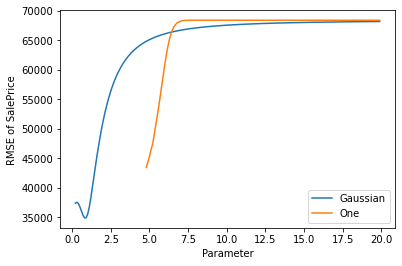

In [62]:
lists = sorted(RMSE_gaussian.items())
x1, y1 = zip(*lists) 

plt.plot(x1, y1, label='Gaussian')

lists = sorted(RMSE_one.items())
x2, y2 = zip(*lists)

plt.plot(x2, y2, label='One')
plt.xlabel('Parameter')
plt.ylabel('RMSE of SalePrice')
plt.legend()
plt.show()

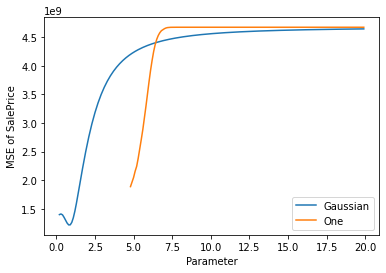

In [63]:
y1 = tuple(i**2 for i in y1) 
plt.plot(x1, y1, label='Gaussian')

y2 = tuple(i**2 for i in y2) 

plt.plot(x2, y2, label='One')
plt.xlabel('Parameter')
plt.ylabel('MSE of SalePrice')
plt.legend()
plt.show()

#### chosse best model to test test.csv

In [56]:
model = Kernel_Regression_Model(train_x, train_y, min_index1)

#### Make a Submission

In [57]:
submisson = pd.DataFrame([model.predict_gaussian(i) for i in test_csv])
submisson = pd.concat([test_df_id, submisson], axis=1, join="inner")
submisson.rename(columns={'Id': 'Id', 0: 'SalePrice'}, inplace=True)
submisson.to_csv('submission.csv', index = False)